In [1]:
print(4.124626e-01 * 1738E3)

716859.9988000001


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from TidalPy import version
print(version)
from TidalPy.RadialSolver import radial_solver,build_rs_input_from_data
from TidalPy.rheology import Elastic, Maxwell, Andrade

weber2011_model = 'model.md'
lmax = 30

# define arrays of interior structure macro layers for integration for each model
layer_types=("solid","liquid", "solid")
is_static_by_layer=(False,True,False)
comp=(False, False, False)
upper_radius_by_layer=(240E3, 331E3, 1738E3)
visc = 1E30
LNs_hp = np.zeros((lmax-1))
LNs_kp = np.zeros((lmax-1))
LNs_lp = np.zeros((lmax-1))
rtol = 1e-8
atol = 1e-8
intmethod = 'RK45'
# Precompute orbital frequency constants
seconds_in_month = 27 * 24 * 60 * 60.
pi_2 = 2 * np.pi
RR = 1738E3

r,rho,vp,vs = np.loadtxt(weber2011_model,usecols=(0,1,2,3),delimiter=None,unpack=True,skiprows=3)
    
# Convert Seismic Velocities to Elastic Moduli
mu = np.ascontiguousarray(np.multiply(np.square(vs),rho))
K  = np.ascontiguousarray(np.subtract(np.multiply(np.square(vp),rho),mu*(4./3.)))
lam = np.ascontiguousarray(np.subtract(K, mu*(2./3.)))

eta   = np.ascontiguousarray(np.full(len(mu),visc))

print(len(mu))

# Precompute forcing frequencies
forcing_frequency = pi_2 / seconds_in_month


shear_rheology_model_tuple = (Elastic(),Elastic(),Elastic())
bulk_rheology_model_tuple = (Elastic(),Elastic(),Elastic())

0.6.5a1.dev6
114


In [3]:
# leave for debugging purposes
rs_inputs = build_rs_input_from_data(
    forcing_frequency,               # Forcing frequency, used to solve for the complex shear / bulk modulus (float64) [rad s-1]
    np.ascontiguousarray(r),                    # np.ndarray for radius values throughout the planet. Must end at the planet's surface (last value = planet radius) [m]. (np.ndarray[double]; len = total_slices)
    np.ascontiguousarray(rho),                   # np.ndarray for density values defined at each radius value [kg m-3]. (np.ndarray[double]; len = total_slices)
    K,       # np.ndarray for static bulk modulus values defined at each radius value [Pa]. (np.ndarray[double]; len = total_slices)
    mu,      # np.ndarray for static shear modulus values defined at each radius value [Pa]. (np.ndarray[double]; len = total_slices)
    eta,            # np.ndarray for bulk viscosity values defined at each radius value [Pa s]. (np.ndarray[double]; len = total_slices)
    eta,           # np.ndarray for shear viscosity values defined at each radius value [Pa s]. (np.ndarray[double]; len = total_slices)
    upper_radius_by_layer,        # Tuple of floats for each layer defining its upper radius value [m]. (Tuple[double]; len = num_layers)
    layer_types,                # Tuple of strings for each layer type. (Tuple[str]; len = num_layers)
    is_static_by_layer,           # Tuple of booleans for if each layer should use the static assumption. (Tuple[bool]; len = num_layers)
    comp,   # Tuple of booleans for if each layer should use the incompressible assumption. (Tuple[bool]; len = num_layers)
    shear_rheology_model_tuple,      # Tuple of rheology instances for each layer's complex shear calculation. (Tuple[RheologyModelBase]; len = num_layers)
    bulk_rheology_model_tuple,       # Tuple of rheology instances for each layer's complex bulk calculation. (Tuple[RheologyModelBase]; len = num_layers)
    perform_checks = True,           # (optional, default=True) Flag to tell function to perform additional checks on inputs. There is a small performance hit, but recommended unless you are sure your input is valid. (boolean)
    warnings = True                  # (optional, default=True) Flag to tell function to raise warnings if it has to make corrections to input arrays. (boolean)
)

Layer 0 does not have its upper radius in the radius array which is required. It will be added; other parameters will be set to their values at the slice just before this upper radius value.
Layer 1 starts at a different radius value than the previous layer's upper radius. Interface radius values must be provided twice, once for each layer above and below the interface. This radius value will be added; other parameters will be set to their values at the slice just after this upper radius value.
Layer 1 does not have its upper radius in the radius array which is required. It will be added; other parameters will be set to their values at the slice just before this upper radius value.
Layer 2 starts at a different radius value than the previous layer's upper radius. Interface radius values must be provided twice, once for each layer above and below the interface. This radius value will be added; other parameters will be set to their values at the slice just after this upper radius value.


In [ ]:
for i in range(2,lmax+1):
    print(i)
    radial_solution = radial_solver(
        *rs_inputs,
        degree_l=i,
        solve_for=('tidal',),
        starting_radius = 680859.9988000001,
        start_radius_tolerance = 1.0e-5,
        use_kamata=True,
        integration_method=intmethod,
        integration_rtol = rtol,
        integration_atol = atol,
        max_num_steps = 100_000_000,
        expected_size = 500,
        max_ram_MB = 1000,
        max_step = 1000,
        nondimensionalize = True,
        verbose = True,
        raise_on_fail = True
        )

    # Extract radial solution components
    
    if i==1:
        kp = radial_solution.k-radial_solution.k
        hp = radial_solution.h-radial_solution.k
        lp = radial_solution.l-radial_solution.k
    else:
        kp = radial_solution.k
        hp = radial_solution.h
        lp = radial_solution.l
    
    LNs_hp[i-2] = hp
    LNs_kp[i-2] = kp
    LNs_lp[i-2] = lp
       

<Figure size 640x480 with 0 Axes>

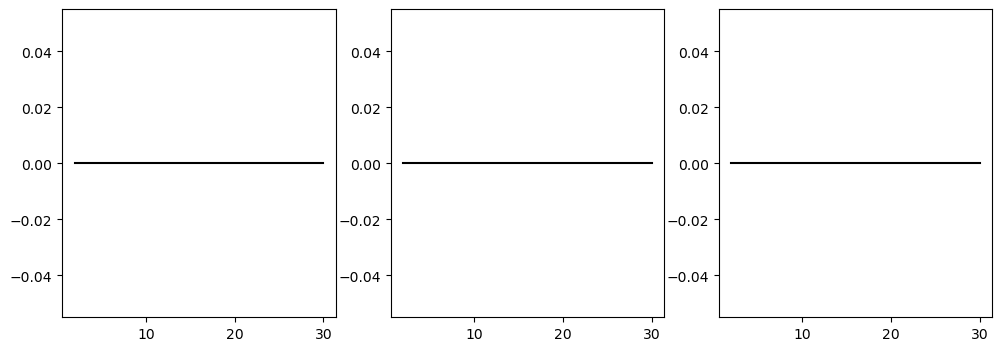

In [3]:
# radial_solution.plot_interior()

plt.clf()
fig, axes = plt.subplots(1, 3, sharex=True, figsize=(12, 4))

axes[0].plot(np.arange(2,lmax+1),LNs_kp, color="k")


axes[1].plot(np.arange(2,lmax+1),LNs_hp, color="k")


axes[2].plot(np.arange(2,lmax+1),LNs_lp, color="k")